## Download Images data

In [ ]:
#Download data
#Over 1 GB

d = False #Already downloaded?

if not d:
    !wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
    !tar -xf images.tar.gz

## Import Libraries 

In [2]:
import os
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from tensorflow.keras.utils import load_img, img_to_array
from kerastuner import HyperModel, RandomSearch

/tmp/ipykernel_2146757/1253164011.py:6: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner import HyperModel, RandomSearch


## Data preprocessing 

In [4]:
#~5k Dog + ~2.4k Cat Breeds
input_dir = "images/"

#pet images
input_img_paths = sorted(
    [os.path.join(input_dir, fname)
     for fname in os.listdir(input_dir)
     if fname.endswith(".jpg")])

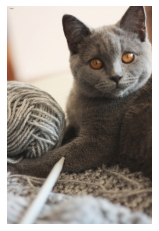

In [5]:
plt.axis("off")
i = 888 #9
plt.imshow(load_img(input_img_paths[i]))

## Split data for classification

In [6]:
#train, test split
#no data iterators; loading to memory.
#ex at the bottom using datafs

import numpy as np
import random

img_size = (200, 200)
num_imgs = len(input_img_paths)

random.Random(1337).shuffle(input_img_paths)

def path_to_input_image(path):
    return img_to_array(load_img(path, target_size=img_size))

input_imgs = np.zeros((num_imgs,) + img_size + (3,), dtype="float32")
for i in range(num_imgs):
    input_imgs[i] = path_to_input_image(input_img_paths[i])


num_val_samples = 1000
num_test_samples = 500
train_input_imgs = input_imgs[:-num_val_samples - num_test_samples]
val_input_imgs = input_imgs[-num_val_samples - num_test_samples: -num_test_samples]
test_input_imgs = input_imgs[-num_test_samples:]

In [7]:
#Not used in the lecture the lecture
#HW
#Create second target matrix for Cat/Dog
#SPECIES:	0:Cat	1:Dog
y_species = np.zeros(len(input_img_paths), dtype=int)

i = 0
for im in input_img_paths:
    title = im[7:].split('.', 1)[0]
    # print(title) #British_Shorthair_47
    ##images	with	small	first	letter	are	dog	images
    if title[0].islower():
        y_species[i] = 1 #Dog found
    i+=1

print("i, # of dogs found, y_shape")
print(i, y_species.sum(), y_species.shape)

i, # of dogs found, y_shape
7390 4990 (7390,)


In [8]:
#Use the same split for classification as segmentation
train_SPECIES = y_species[:-num_val_samples - num_test_samples]
val_SPECIES = y_species[-num_val_samples - num_test_samples: -num_test_samples]
test_SPECIES = y_species[-num_test_samples:]

# Comparing with CNN , Dilated CNN, HDC

## CNN

In [39]:
def get_model(img_size):
    #Input: Get image
    inputs = keras.Input(shape=img_size + (3,))
    #Scale
    x = layers.Rescaling(1./255)(inputs)

    #Conv layers
    # (200,200,3)
    #Part 1: Encode: 128 -> 256
    x = layers.Conv2D(filters=32,kernel_size=2,activation="relu")(x)
    x= layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(filters=64,kernel_size=2,activation="relu")(x)
    x= layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(filters=128,kernel_size=2,activation="relu")(x)
    x= layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(filters=256,kernel_size=2,activation="relu")(x)
    x= layers.MaxPooling2D((2, 2))(x)

    # Species prediction output
    #transition from CNN to DNN: Makes it 1-D (matrix to vector)
    x = layers.Flatten()(x)
    # Full Connected newtwork
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(128, activation="relu")(x)
    species_output = layers.Dense(1, activation="sigmoid")(x)

    model = keras.Model(inputs, outputs=species_output)
    return model

#Set up
keras.backend.clear_session()
model = get_model(img_size=img_size)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 200, 200, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 199, 199, 32)      416       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 99, 99, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 98, 98, 64)        8256      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 49, 49, 64)       0         
 2D)                                                         

In [40]:
model.compile(optimizer='rmsprop',
              loss=['binary_crossentropy'],
              metrics=['accuracy'])
history = model.fit(x=train_input_imgs, y=train_SPECIES, epochs=30, batch_size=32,
                    validation_data=(val_input_imgs, val_SPECIES))



Epoch 1/30
185/185 [==============================] - 4s 15ms/step - loss: 0.6257 - accuracy: 0.6701 - val_loss: 0.5840 - val_accuracy: 0.6850
Epoch 2/30
185/185 [==============================] - 2s 12ms/step - loss: 0.5667 - accuracy: 0.6920 - val_loss: 0.5880 - val_accuracy: 0.6830
Epoch 3/30
185/185 [==============================] - 2s 12ms/step - loss: 0.5405 - accuracy: 0.7219 - val_loss: 0.6028 - val_accuracy: 0.7090
Epoch 4/30
185/185 [==============================] - 2s 12ms/step - loss: 0.5044 - accuracy: 0.7570 - val_loss: 0.4900 - val_accuracy: 0.7780
Epoch 5/30
185/185 [==============================] - 2s 12ms/step - loss: 0.4661 - accuracy: 0.7835 - val_loss: 0.6203 - val_accuracy: 0.7240
Epoch 6/30
185/185 [==============================] - 2s 12ms/step - loss: 0.4365 - accuracy: 0.7981 - val_loss: 0.5240 - val_accuracy: 0.7520
Epoch 7/30
185/185 [==============================] - 2s 12ms/step - loss: 0.4033 - accuracy: 0.8229 - val_loss: 0.5175 - val_accuracy: 0.7720

<Figure size 864x648 with 0 Axes>

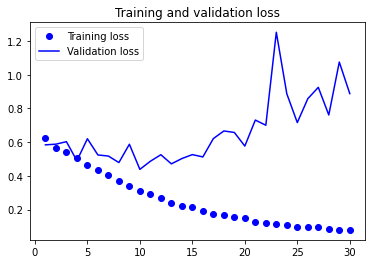

In [41]:
plt.figure(figsize=(12, 9))
epochs = range(1, len(history.history["loss"]) + 1)
loss = history.history["loss"]
val_loss = history.history["val_loss"]
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")

plt.title("Training and validation loss")
plt.legend()
plt.savefig('./plots/CNN_loss.png')
plt.show()

<Figure size 864x648 with 0 Axes>

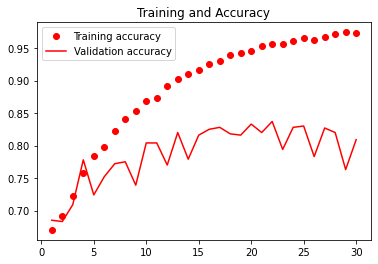

In [42]:
plt.figure(figsize=(12, 9))
epochs = range(1, len(history.history["loss"]) + 1)
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
plt.figure()
plt.plot(epochs, accuracy, "ro", label="Training accuracy")
plt.plot(epochs, val_accuracy, "r", label="Validation accuracy")

plt.title("Training and Accuracy")
plt.legend()
plt.savefig('./plots/CNN_acc.png')
plt.show()

## Dilated CNN (with same dilated kernal size)

In [43]:
from tensorflow import keras
from tensorflow.keras import layers
def get_model(img_size):
    #Input: Get image
    inputs = keras.Input(shape=img_size + (3,))
    #Scale
    x = layers.Rescaling(1./255)(inputs)

    #Conv layers
    # (200,200,3)
    #Part 1: Encode: 64 -> 256
    x = layers.Conv2D(filters=32,kernel_size=2,activation="relu", dilation_rate=(2, 2))(x)
    x= layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(filters=64,kernel_size=2,activation="relu", dilation_rate=(2, 2))(x)
    x= layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(filters=128,kernel_size=2,activation="relu", dilation_rate=(2, 2))(x)
    x= layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(filters=256,kernel_size=2,activation="relu", dilation_rate=(2, 2))(x)
    x= layers.MaxPooling2D((2, 2))(x)
    # Species prediction output
    #transition from CNN to DNN: Makes it 1-D (matrix to vector)
    x = layers.Flatten()(x)
    # Full Connected newtwork
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(128, activation="relu")(x)
    species_output = layers.Dense(1, activation="sigmoid")(x)

    model = keras.Model(inputs, outputs=species_output)
    return model
keras.backend.clear_session()
model = get_model(img_size=img_size)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 200, 200, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 198, 198, 32)      416       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 99, 99, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 97, 64)        8256      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 48, 48, 64)       0         
 2D)                                                         

In [44]:
model.compile(optimizer='rmsprop',
              loss=['binary_crossentropy'],
              metrics=['accuracy'])

history = model.fit(x=train_input_imgs, y=train_SPECIES, epochs=30, batch_size=32,
                    validation_data=(val_input_imgs, val_SPECIES))


Epoch 1/30
185/185 [==============================] - 6s 24ms/step - loss: 0.6240 - accuracy: 0.6730 - val_loss: 0.6146 - val_accuracy: 0.6850
Epoch 2/30
185/185 [==============================] - 4s 20ms/step - loss: 0.5619 - accuracy: 0.6922 - val_loss: 0.5343 - val_accuracy: 0.7230
Epoch 3/30
185/185 [==============================] - 4s 20ms/step - loss: 0.5295 - accuracy: 0.7431 - val_loss: 0.5287 - val_accuracy: 0.7420
Epoch 4/30
185/185 [==============================] - 4s 20ms/step - loss: 0.4934 - accuracy: 0.7647 - val_loss: 0.6122 - val_accuracy: 0.7100
Epoch 5/30
185/185 [==============================] - 4s 20ms/step - loss: 0.4451 - accuracy: 0.7963 - val_loss: 0.4977 - val_accuracy: 0.7710
Epoch 6/30
185/185 [==============================] - 4s 20ms/step - loss: 0.4103 - accuracy: 0.8185 - val_loss: 0.5374 - val_accuracy: 0.7450
Epoch 7/30
185/185 [==============================] - 4s 20ms/step - loss: 0.3852 - accuracy: 0.8255 - val_loss: 0.4528 - val_accuracy: 0.7880

<Figure size 864x648 with 0 Axes>

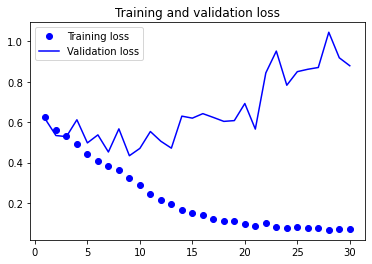

In [45]:
plt.figure(figsize=(12, 9))
epochs = range(1, len(history.history["loss"]) + 1)
loss = history.history["loss"]
val_loss = history.history["val_loss"]
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")

plt.title("Training and validation loss")
plt.legend()
plt.savefig('./plots/dilated_CNN_loss.png')
plt.show()

<Figure size 864x648 with 0 Axes>

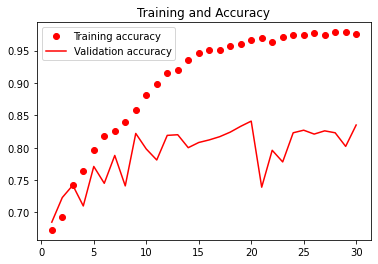

In [46]:
plt.figure(figsize=(12, 9))
epochs = range(1, len(history.history["loss"]) + 1)
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
plt.figure()
plt.plot(epochs, accuracy, "ro", label="Training accuracy")
plt.plot(epochs, val_accuracy, "r", label="Validation accuracy")

plt.title("Training and Accuracy")
plt.legend()
plt.savefig('./plots/dilated_CNN_acc.png')
plt.show()

## HDC model(hybrid dilated CNN, CNN with dilated convolution kernels and different dilation rates)

In [47]:
def get_model(img_size):
    #Input: Get image
    inputs = keras.Input(shape=img_size + (3,))
    #Scale
    x = layers.Rescaling(1./255)(inputs)

    #Conv layers
    # (200,200,3)
    #Part 1: Encode: 64 -> 256
    x = layers.Conv2D(filters=32,kernel_size=3,activation="relu", dilation_rate=(1, 1))(x)
    x= layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(filters=64,kernel_size=3,activation="relu", dilation_rate=(2, 2))(x)
    x= layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(filters=128,kernel_size=3,activation="relu", dilation_rate=(1, 1))(x)
    x= layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(filters=256,kernel_size=3,activation="relu", dilation_rate=(2, 2))(x)
    x= layers.MaxPooling2D((2, 2))(x)
    # Species prediction output
    #transition from CNN to DNN: Makes it 1-D (matrix to vector)
    x = layers.Flatten()(x)
    # Full Connected newtwork
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(128, activation="relu")(x)
    species_output = layers.Dense(1, activation="sigmoid")(x)

    model = keras.Model(inputs, outputs=species_output)
    return model
keras.backend.clear_session()
model = get_model(img_size=img_size)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 200, 200, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 198, 198, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 99, 99, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 95, 95, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 47, 47, 64)       0         
 2D)                                                         

In [48]:
model.compile(optimizer='rmsprop',
              loss=['binary_crossentropy'],
              metrics=['accuracy'])
history = model.fit(x=train_input_imgs, y=train_SPECIES, epochs=30, batch_size=32,
                    validation_data=(val_input_imgs, val_SPECIES))

Epoch 1/30
185/185 [==============================] - 5s 20ms/step - loss: 0.6509 - accuracy: 0.6728 - val_loss: 0.6288 - val_accuracy: 0.6850
Epoch 2/30
185/185 [==============================] - 3s 16ms/step - loss: 0.5984 - accuracy: 0.6732 - val_loss: 0.5544 - val_accuracy: 0.6850
Epoch 3/30
185/185 [==============================] - 3s 16ms/step - loss: 0.5537 - accuracy: 0.7100 - val_loss: 0.5493 - val_accuracy: 0.7100
Epoch 4/30
185/185 [==============================] - 3s 17ms/step - loss: 0.5151 - accuracy: 0.7538 - val_loss: 0.5592 - val_accuracy: 0.7100
Epoch 5/30
185/185 [==============================] - 3s 16ms/step - loss: 0.4737 - accuracy: 0.7781 - val_loss: 0.4716 - val_accuracy: 0.7830
Epoch 6/30
185/185 [==============================] - 3s 17ms/step - loss: 0.4405 - accuracy: 0.7935 - val_loss: 0.4496 - val_accuracy: 0.7940
Epoch 7/30
185/185 [==============================] - 3s 17ms/step - loss: 0.3984 - accuracy: 0.8216 - val_loss: 0.4248 - val_accuracy: 0.8030

<Figure size 864x648 with 0 Axes>

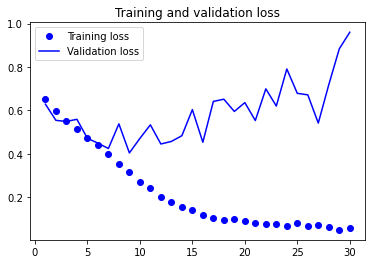

In [49]:
plt.figure(figsize=(12, 9))
epochs = range(1, len(history.history["loss"]) + 1)
loss = history.history["loss"]
val_loss = history.history["val_loss"]
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")

plt.title("Training and validation loss")
plt.legend()
plt.savefig('./plots/HDC_loss.png')
plt.show()

<Figure size 864x648 with 0 Axes>

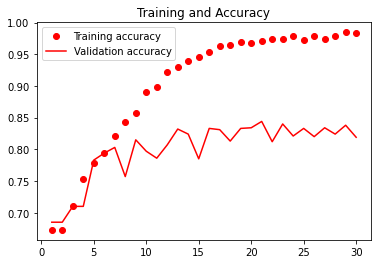

In [50]:
plt.figure(figsize=(12, 9))
epochs = range(1, len(history.history["loss"]) + 1)
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
plt.figure()
plt.plot(epochs, accuracy, "ro", label="Training accuracy")
plt.plot(epochs, val_accuracy, "r", label="Validation accuracy")

plt.title("Training and Accuracy")
plt.legend()
plt.savefig('./plots/HDC_acc.png')
plt.show()

------

# Part2

## finding Best CNN

In [26]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),  #range for random flip: 50%
        layers.RandomRotation(0.1),  #range for random rotation: +/- 10%
        layers.RandomZoom(0.2), #range for random zoom: +/- 20%
    ]
)

In [27]:
def get_model(img_size):
    #Input: Get image
    inputs = keras.Input(shape=img_size + (3,))

    #Conv layers
    # (200,200,3)
    #Part 1: Encode: 64 -> 256
    x = data_augmentation(inputs)
    x = layers.Rescaling(1./255)(x)
    x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
    x = layers.Flatten()(x)
    x = layers.Dropout(0.4)(x) 
    x = layers.Dense(64, activation="sigmoid")(x)
    x = layers.Dropout(0.4)(x) 
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs=inputs, outputs=outputs)

    return model
keras.backend.clear_session()
model = get_model(img_size=img_size)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 200, 200, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 200, 200, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 198, 198, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 99, 99, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 97, 64)        18496     
                                                             

In [35]:
model.compile(optimizer='rmsprop',
              loss=['binary_crossentropy'],
              metrics=['accuracy'])
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="best_cnn.keras",
        save_best_only=True,
        mode='max',
        monitor="val_loss"),
        
    keras.callbacks.EarlyStopping(
        monitor = "val_accuracy",
        patience = 5,
        mode='max',
    ),
]
history = model.fit(x=train_input_imgs, y=train_SPECIES, epochs=30, batch_size=32,
                    validation_data=(val_input_imgs, val_SPECIES),callbacks=callbacks)

Epoch 1/30
185/185 [==============================] - 17s 79ms/step - loss: 0.3634 - accuracy: 0.8416 - val_loss: 0.4990 - val_accuracy: 0.7730
Epoch 2/30
185/185 [==============================] - 14s 76ms/step - loss: 0.3597 - accuracy: 0.8397 - val_loss: 0.2587 - val_accuracy: 0.8860
Epoch 3/30
185/185 [==============================] - 14s 76ms/step - loss: 0.3510 - accuracy: 0.8458 - val_loss: 0.2729 - val_accuracy: 0.8830
Epoch 4/30
185/185 [==============================] - 14s 77ms/step - loss: 0.3288 - accuracy: 0.8616 - val_loss: 0.2812 - val_accuracy: 0.8760
Epoch 5/30
185/185 [==============================] - 14s 75ms/step - loss: 0.3357 - accuracy: 0.8553 - val_loss: 0.3251 - val_accuracy: 0.8510
Epoch 6/30
185/185 [==============================] - 14s 76ms/step - loss: 0.3403 - accuracy: 0.8576 - val_loss: 0.4189 - val_accuracy: 0.8060
Epoch 7/30
185/185 [==============================] - 14s 77ms/step - loss: 0.3271 - accuracy: 0.8604 - val_loss: 0.2712 - val_accuracy:

<Figure size 864x648 with 0 Axes>

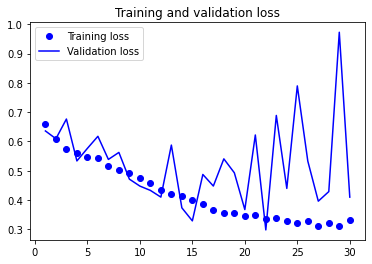

In [33]:
plt.figure(figsize=(12, 9))
epochs = range(1, len(history.history["loss"]) + 1)
loss = history.history["loss"]
val_loss = history.history["val_loss"]
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")

plt.title("Training and validation loss")
plt.legend()
plt.savefig('./plots/best_CNN_loss.png')
plt.show()

<Figure size 864x648 with 0 Axes>

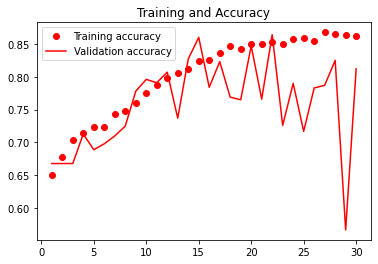

In [34]:
plt.figure(figsize=(12, 9))
epochs = range(1, len(history.history["loss"]) + 1)
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
plt.figure()
plt.plot(epochs, accuracy, "ro", label="Training accuracy")
plt.plot(epochs, val_accuracy, "r", label="Validation accuracy")

plt.title("Training and Accuracy")
plt.legend()
plt.savefig('./plots/best_CNN_acc.png')
plt.show()

----------------------------

# finding Best dilated CNN model

In [20]:
def get_model(img_size):
    #Input: Get image
    inputs = keras.Input(shape=img_size + (3,))

    #Conv layers
    # (200,200,3)
    #Part 1: Encode: 64 -> 256
    x = data_augmentation(inputs)
    x = layers.Rescaling(1./255)(x)
    x = layers.Conv2D(filters=32, kernel_size=3, activation="relu",dilation_rate=(2, 2))(x)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Conv2D(filters=64, kernel_size=3, activation="relu",dilation_rate=(2, 2))(x)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Conv2D(filters=128, kernel_size=3, activation="relu",dilation_rate=(2, 2))(x)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Conv2D(filters=256, kernel_size=3, activation="relu",dilation_rate=(2, 2))(x)
    x = layers.Flatten()(x)
    x = layers.Dropout(0.4)(x) 
    x = layers.Dense(64, activation="sigmoid")(x)
    x = layers.Dropout(0.4)(x) 
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs=inputs, outputs=outputs)

    return model
keras.backend.clear_session()
model = get_model(img_size=img_size)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 200, 200, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 200, 200, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 196, 196, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 98, 98, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 94, 94, 64)        18496     
                                                             

In [40]:
model.compile(optimizer='rmsprop',
              loss=['binary_crossentropy'],
              metrics=['accuracy'])
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="best_dilated_cnn.keras",
        save_best_only=True,
        monitor="val_accuracy",
        mode='max',),
    keras.callbacks.EarlyStopping(
        monitor = "val_accuracy",
        patience = 5,
        mode='max',
    ),
]
history = model.fit(x=train_input_imgs, y=train_SPECIES, epochs=30, batch_size=32,
                    validation_data=(val_input_imgs, val_SPECIES),callbacks=callbacks)

Epoch 1/30
185/185 [==============================] - 17s 80ms/step - loss: 0.3214 - accuracy: 0.8643 - val_loss: 0.4044 - val_accuracy: 0.8260
Epoch 2/30
185/185 [==============================] - 14s 78ms/step - loss: 0.3176 - accuracy: 0.8681 - val_loss: 0.2712 - val_accuracy: 0.8770
Epoch 3/30
185/185 [==============================] - 15s 79ms/step - loss: 0.3202 - accuracy: 0.8667 - val_loss: 0.2920 - val_accuracy: 0.8710
Epoch 4/30
185/185 [==============================] - 14s 76ms/step - loss: 0.3158 - accuracy: 0.8716 - val_loss: 0.3196 - val_accuracy: 0.8740
Epoch 5/30
185/185 [==============================] - 15s 78ms/step - loss: 0.3191 - accuracy: 0.8706 - val_loss: 0.6212 - val_accuracy: 0.6910
Epoch 6/30
185/185 [==============================] - 14s 77ms/step - loss: 0.3176 - accuracy: 0.8649 - val_loss: 0.4220 - val_accuracy: 0.8180
Epoch 7/30
185/185 [==============================] - 15s 78ms/step - loss: 0.3127 - accuracy: 0.8722 - val_loss: 0.4115 - val_accuracy:

<Figure size 864x648 with 0 Axes>

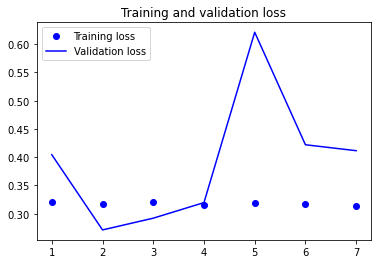

In [41]:
plt.figure(figsize=(12, 9))
epochs = range(1, len(history.history["loss"]) + 1)
loss = history.history["loss"]
val_loss = history.history["val_loss"]
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")

plt.title("Training and validation loss")
plt.legend()
plt.savefig('./plots/best_dilated_CNN_loss.png')
plt.show()

<Figure size 864x648 with 0 Axes>

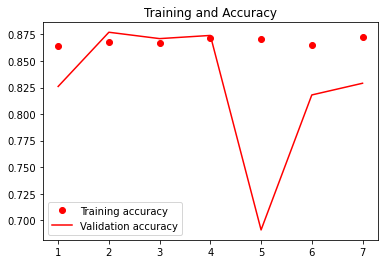

In [42]:
plt.figure(figsize=(12, 9))
epochs = range(1, len(history.history["loss"]) + 1)
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
plt.figure()
plt.plot(epochs, accuracy, "ro", label="Training accuracy")
plt.plot(epochs, val_accuracy, "r", label="Validation accuracy")

plt.title("Training and Accuracy")
plt.legend()
plt.savefig('./plots/best_dilated_CNN_acc.png')
plt.show()

# finding Best HDC model

In [49]:
def get_model(img_size):
    #Input: Get image
    inputs = keras.Input(shape=img_size + (3,))

    #Conv layers
    # (200,200,3)
    #Part 1: Encode: 64 -> 256
    x = data_augmentation(inputs)
    x = layers.Rescaling(1./255)(x)
    x = layers.Conv2D(filters=32, kernel_size=3, activation="relu",dilation_rate=(1, 1))(x)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Conv2D(filters=64, kernel_size=3, activation="relu",dilation_rate=(2, 2))(x)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Conv2D(filters=128, kernel_size=3, activation="relu",dilation_rate=(1, 1))(x)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Conv2D(filters=256, kernel_size=3, activation="relu",dilation_rate=(2, 2))(x)
    x = layers.Flatten()(x)
    x = layers.Dropout(0.4)(x) 
    x = layers.Dense(64, activation="sigmoid")(x)
    x = layers.Dropout(0.4)(x) 
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs=inputs, outputs=outputs)

    return model
keras.backend.clear_session()
model = get_model(img_size=img_size)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 200, 200, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 200, 200, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 198, 198, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 99, 99, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 95, 95, 64)        18496     
                                                             

In [50]:
model.compile(optimizer='rmsprop',
              loss=['binary_crossentropy'],
              metrics=['accuracy'])
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="best_HDC_dilated_cnn.keras",
        save_best_only=True,
        monitor="val_accuracy",
        mode='max',),
        
    keras.callbacks.EarlyStopping(
        monitor = "val_accuracy",
        patience = 5,
        mode='max',
    ),
]
history = model.fit(x=train_input_imgs, y=train_SPECIES, epochs=30, batch_size=32,
                    validation_data=(val_input_imgs, val_SPECIES),callbacks=callbacks)

Epoch 1/30
185/185 [==============================] - 18s 82ms/step - loss: 0.6624 - accuracy: 0.6633 - val_loss: 0.6513 - val_accuracy: 0.6270
Epoch 2/30
185/185 [==============================] - 15s 80ms/step - loss: 0.5936 - accuracy: 0.6842 - val_loss: 0.5690 - val_accuracy: 0.6810
Epoch 3/30
185/185 [==============================] - 15s 80ms/step - loss: 0.5706 - accuracy: 0.6971 - val_loss: 0.5626 - val_accuracy: 0.7000
Epoch 4/30
185/185 [==============================] - 15s 79ms/step - loss: 0.5506 - accuracy: 0.7200 - val_loss: 0.6609 - val_accuracy: 0.6690
Epoch 5/30
185/185 [==============================] - 15s 80ms/step - loss: 0.5315 - accuracy: 0.7377 - val_loss: 0.5319 - val_accuracy: 0.7290
Epoch 6/30
185/185 [==============================] - 15s 78ms/step - loss: 0.5184 - accuracy: 0.7423 - val_loss: 0.4901 - val_accuracy: 0.7520
Epoch 7/30
185/185 [==============================] - 15s 80ms/step - loss: 0.4998 - accuracy: 0.7555 - val_loss: 0.5025 - val_accuracy:

<Figure size 864x648 with 0 Axes>

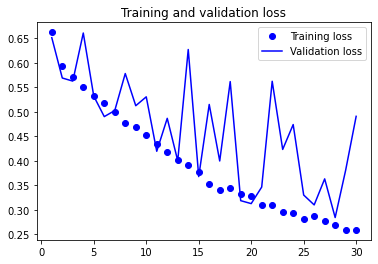

In [51]:
plt.figure(figsize=(12, 9))
epochs = range(1, len(history.history["loss"]) + 1)
loss = history.history["loss"]
val_loss = history.history["val_loss"]
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")

plt.title("Training and validation loss")
plt.legend()
plt.savefig('./plots/best_HDC_loss.png')
plt.show()

<Figure size 864x648 with 0 Axes>

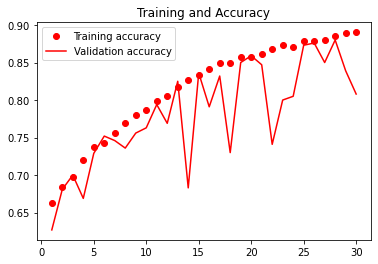

In [52]:
plt.figure(figsize=(12, 9))
epochs = range(1, len(history.history["loss"]) + 1)
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
plt.figure()
plt.plot(epochs, accuracy, "ro", label="Training accuracy")
plt.plot(epochs, val_accuracy, "r", label="Validation accuracy")

plt.title("Training and Accuracy")
plt.legend()
plt.savefig('./plots/best_HDC_acc.png')
plt.show()

---------------------------

# Testing 

In [53]:
model_history = model.history
num_epochs = len(model_history.history['loss'])
print(f"The model was trained for {num_epochs} epochs.")

The model was trained for 30 epochs.


In [63]:
from sklearn.metrics import confusion_matrix, accuracy_score
from keras.models import load_model
# 'best_cnn.keras'
# 'best_dilated_cnn.keras'
# 'best_HDC_dilated_cnn.keras'

model_check = load_model('best_HDC_dilated_cnn.keras')
test_predictions = model_check.predict(test_input_imgs)
threshold = 0.5  # Adjust the threshold as needed
predicted_classes = (test_predictions > threshold).astype(int)
accuracy = accuracy_score(test_SPECIES, predicted_classes)
confusion = confusion_matrix(test_SPECIES, predicted_classes)
accuracy

16/16 [==============================] - 0s 6ms/step


0.882

In [ ]:
confusion

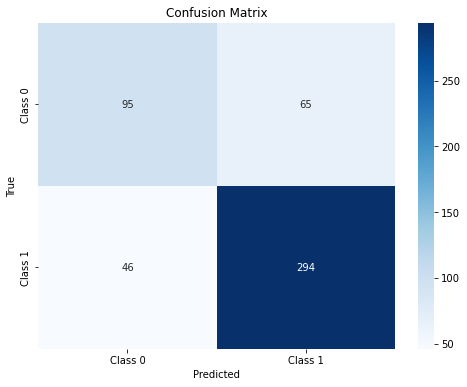

In [75]:
import matplotlib.pyplot as plt
import seaborn as sns

class_labels = ['Class 0', 'Class 1']  # Update with your class labels

plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

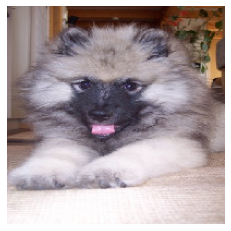

In [33]:
from tensorflow.keras.utils import array_to_img
i = 69 #4
test_image = val_input_imgs[i]
plt.axis("off")
plt.imshow(array_to_img(test_image))

In [34]:
# 0:Cat	1:Dog
species_predictation = model.predict(np.expand_dims(test_image, 0))
if species_predictation <=0.5:
    print("this is a cat")
else:
    print("this is a dog")

1/1 [==============================] - 0s 23ms/step
this is a dog
